In [1]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
from collections import OrderedDict
# import pymc3 as pm

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [16]:
def combine_deep_fields(fields, csfq, ssfq, masscut_low, masscut_high, z, path, sample='',bin_number=14):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
    affix = '_' + sample+ str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    
    radial_combine = np.zeros(bin_number)
    radial_err_combine =  np.zeros(bin_number)
    n_fields = []
    for field in fields:
        data_field = np.genfromtxt(path+'count'+field+affix)
        split_index = int(((len(data_field)-1)/2)+1)
            
        n_field = data_field[0]
        radial_field = data_field[1:split_index]
        radial_field_err = data_field[split_index:]
        
        n_fields.append(n_field)
        radial_combine = np.vstack([radial_combine, radial_field])
        radial_err_combine = np.vstack([radial_err_combine, radial_field_err])
        
    # remove the zeros line
    radial_combine = radial_combine[1:,:]
    radial_err_combine = radial_err_combine[1:,:]
    
    n_tot = sum(n_fields)   
    radial = np.average(radial_combine, axis=0, weights=n_fields)
    radial_err = np.sqrt(sum(radial_err_combine**2*n_field**2))/sum(n_fields)
    return (radial, radial_err, n_tot)

def load_deep(field_name, csfq, ssfq, masscut_low, masscut_high, z, path, sample=''):
    if isinstance(z,str):
        pass
    elif isinstance(z,float):
        z = str(round(z, 1))
        
    if sample != '': sample+='_'
            
    affix = '_' + sample + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + z +'.txt'
    field_deep = np.genfromtxt(path+'count'+field_name+affix)
    n_field = int(field_deep[0])
    
    split_index = int(((len(field_deep)-1)/2)+1)
    radial_field = field_deep[1:split_index]
    radial_field_err = field_deep[split_index:]
    return (radial_field, radial_field_err, n_field)

In [3]:
bin_number=14
bin_edges_areas = 10 ** np.linspace(1.0, np.log10(700), num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)

### NFW model

In [7]:
def nfw(r, rs, I):
    x = r / float(rs)
    y = np.piecewise(x, [x < 1, x==1, x > 1],
                     [lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(1-x**2)*np.arctanh(np.sqrt((1-x)/(1+x)))), 
                      lambda x:I*1./3, 
                      lambda x:I*(x**2-1)**(-1)*(1-2/np.sqrt(x**2-1)*np.arctan(np.sqrt((x-1)/(1+x))))])
    return y

def fit_nfw(xdata, ydata, ydata_err, start):
    popt,pcov = curve_fit(nfw, xdata[start-1:], ydata[start-1:], sigma=ydata_err[start-1:])
    
    res = ydata - nfw(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

### Sersic + NFW model

In [6]:
def sersic(r,Ie,re,n):
#     n=5.5
    b=2*n-1./3
    sersic = Ie * np.exp(-b*((r/float(re))**(1/float(n))-1))
    return sersic

def nfw_sersic(r, rs, I, Ie,re, n):
    sersic_val = sersic(r,Ie,re,n)
    nfw_val = nfw(r,rs,I)
    return nfw_val + sersic_val

def fit_nfw_sersic(xdata, ydata, ydata_err, start,end=-1):
    xdata = xdata[start-1:end]
    ydata = ydata[start-1:end]
    ydata_err = ydata_err[start-1:end]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,3e-5,4.2e-5,15.1, 5.5]
                          ,bounds=([0, 0, 0 ,0 ,0],[10000, 2e-2, 2e-2, 300, 40]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

def fit_nfw_sersic_fix_n(xdata, ydata, ydata_err, start,fix_n=0.26):
    xdata = xdata[start-1:]
    ydata = ydata[start-1:]
    ydata_err = ydata_err[start-1:]
    popt,pcov = curve_fit(nfw_sersic, xdata, ydata, sigma=ydata_err, p0=[250,3e-5,4.2e-5,15.1, 0.26]
                          ,bounds=([0, 0, 0 ,0 ,fix_n-0.001],[10000, 2e-2, 2e-2, 300, fix_n+0.001]),maxfev=10000)
    res = ydata - nfw_sersic(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

### Total Satellite Sample

In [8]:
def red_frac_err_new(q, All, q_err, all_err):
    return np.sqrt( q_err**2*(1/All)**2 + all_err**2*(q/All**2)**2)

['ELAIS_deep', 'DEEP_deep', 'COSMOS_deep', 'XMM-LSS_deep']
fitting NFW+Sersic
dof: 6
--------all---------
[5.889e+02 1.185e-05 3.273e-05 3.903e+01 8.881e-01] [3.050e+02 5.345e-06 8.945e-06 8.948e+00 7.772e-01] Chi2_dof=3.35
[7.392e+02 8.496e-06 2.675e-05 5.564e+01 1.084e+00] [3.988e+02 4.009e-06 4.700e-06 1.058e+01 3.620e-01] Chi2_dof=0.32
[5.447e+02 1.564e-05 3.620e-05 3.473e+01 2.610e-01] [1.855e+02 4.277e-06 8.544e-06 5.876e+00 2.070e-01] Chi2_dof=13.29


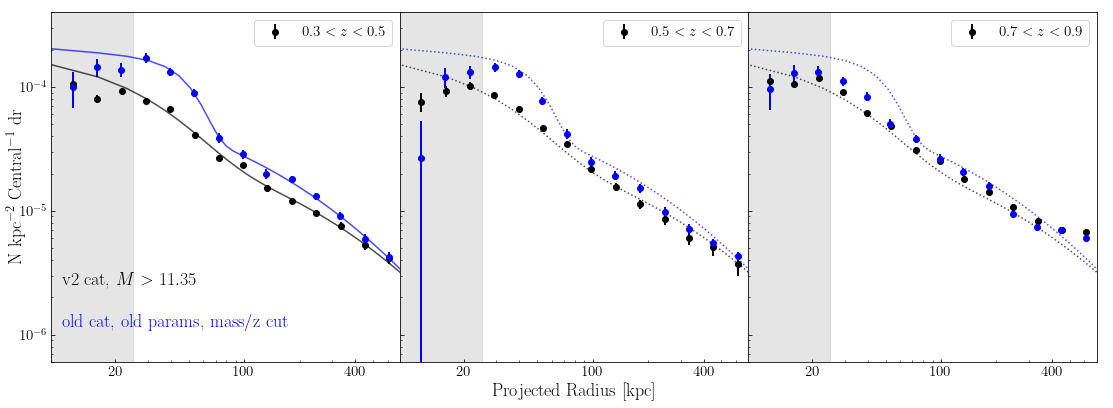

In [50]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16,6))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)

sample_all=''
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep','XMM-LSS_deep']
print(field_names)

#============= primary data ============
csfq = 'all'
path = 'CUT_deep_catalogs/radial_dist_code/total_sample_v8/' 
sample_name1 = r'v2 cat, $M>11.35$'

bin_edges = np.load(path+'bin_centers.npy')*offset
count_radial_4 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.4,path,sample=sample_all)
count_radial_6 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.6,path,sample=sample_all)
count_radial_8 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.8,path,sample=sample_all)

# ============ secondary data ============
csfq = 'all'
path2 = 'CUT_deep_catalogs/total_sample_0330/'
sample_name2 = 'old cat, old params, mass/z cut'

bin_edges2 = np.load(path2+'bin_centers.npy')
count_radial_4_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.4,path2,sample=sample_all)
count_radial_6_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.6,path2,sample=sample_all)
count_radial_8_2 = combine_deep_fields(field_names, csfq,'all','9.5','13.0',0.8,path2,sample=sample_all)

#==============plot====================
axs[0].errorbar(bin_edges, count_radial_4[0],count_radial_4[1],fmt='ok',label=r'$0.3<z<0.5$',linewidth=2)
axs[1].errorbar(bin_edges, count_radial_6[0],count_radial_6[1],fmt='ok',label=r'$0.5<z<0.7$',linewidth=2)
axs[2].errorbar(bin_edges, count_radial_8[0],count_radial_8[1],fmt='ok',label=r'$0.7<z<0.9$',linewidth=2)

axs[0].errorbar(bin_edges2, count_radial_4_2[0],count_radial_4_2[1],fmt='ob',linewidth=2)
axs[1].errorbar(bin_edges2, count_radial_6_2[0],count_radial_6_2[1],fmt='ob',linewidth=2)
axs[2].errorbar(bin_edges2, count_radial_8_2[0],count_radial_8_2[1],fmt='ob',linewidth=2)

axs[0].set_yscale('log')
axs[0].set_xscale('log')

#========= fitting =====================
fit_x = np.linspace(2,700,num=100)
start = 4

# NFW + Sersic Fitting
print('fitting NFW+Sersic')
model = 'NFW_Sersic'
popt4,pcov4,chi2_4 = fit_nfw_sersic(bin_edges,count_radial_4[0],count_radial_4[1], start)
popt6,pcov6,chi2_6 = fit_nfw_sersic(bin_edges,count_radial_6[0],count_radial_6[1], start)
popt8,pcov8,chi2_8 = fit_nfw_sersic_fix_n(bin_edges,count_radial_8[0],count_radial_8[1], start)

perr4 = np.sqrt(np.diag(pcov4))
perr6 = np.sqrt(np.diag(pcov6))
perr8 = np.sqrt(np.diag(pcov8))

popt42,pcov42,chi2_42 = fit_nfw_sersic(bin_edges,count_radial_4_2[0],count_radial_4_2[1], start)

#=========== Plot Model ==================
axs[0].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),'k',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt4[0],popt4[1],popt4[2],popt4[3],popt4[4]),':k',alpha=0.7)

axs[0].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),'b',alpha=0.7)
axs[1].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)
axs[2].plot(fit_x,nfw_sersic(fit_x, popt42[0],popt42[1],popt42[2],popt42[3],popt42[4]),':b',alpha=0.7)

np.set_printoptions(precision=3)
dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print('dof:',dof)
print('--------all---------')
print(popt4,perr4,'Chi2_dof='+str(round(chi2_4/dof,2)))
print(popt6,perr6,'Chi2_dof='+str(round(chi2_6/dof,2)))
print(popt8,perr8,'Chi2_dof='+str(round(chi2_8/dof,2)))

# print all,sf,q info on figure
axs[0].annotate(sample_name1,xy=([0.03,0.22]),xycoords='axes fraction',fontsize=18)
axs[0].annotate(sample_name2,xy=([0.03,0.10]),xycoords='axes fraction',fontsize=18,color='b')

#=========
axs[0].axvspan(9, 25, alpha=0.1, color='k')
axs[1].axvspan(9, 25, alpha=0.1, color='k')
axs[2].axvspan(9, 25, alpha=0.1, color='k')

axs[0].legend(fontsize=15)
axs[1].legend(fontsize=15)
axs[2].legend(fontsize=15)
axs[0].set_xticks([20, 100, 400])
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].set_xlim([9,700])
axs[0].set_ylim([6e-7,4e-4])

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

plt.xlabel('Projected Radius [kpc]', fontsize=18)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
# plt.title(r'Number Density Redshift Dependence ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

plt.show() 

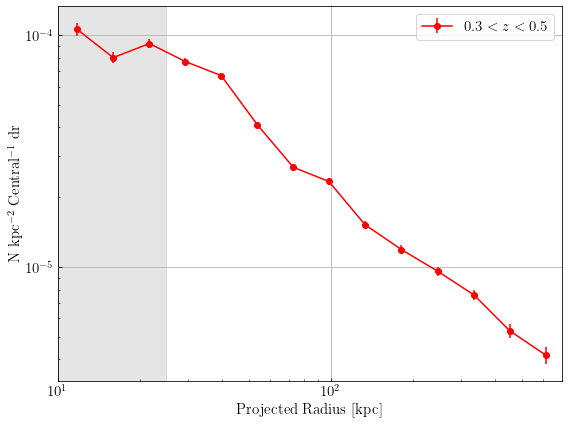

In [32]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,6))
field_names = ['DEEP_deep','ELAIS_deep','XMM-LSS_deep','COSMOS_deep']

path = 'CUT_deep_catalogs/radial_dist_code/total_sample_v8/' # constant mass cut

radial_4 = combine_deep_fields(field_names, 'all', 'all','9.5','13.0', 0.4,path,sample='')
radial_6 = combine_deep_fields(field_names, 'all','all','9.5','13.0', 0.6,path,sample='')
radial_8 = combine_deep_fields(field_names, 'all','all','9.5','13.0', 0.8,path,sample='')

bin_centers = np.load(path+'bin_centers.npy')
plt.errorbar(bin_centers, radial_4[0],yerr=radial_4[1],fmt='or-',label='$0.3<z<0.5$')
# plt.errorbar(bin_centers, radial_6[0],yerr=radial_6[1],fmt='og-',label='$0.5<z<0.7$')
# plt.errorbar(bin_centers, radial_8[0],yerr=radial_8[1],fmt='ob-',label='$0.7<z<0.9$')

plt.axhline(2e-5,10,700,linewidth=4, color='r')
plt.axvspan(10, 25, alpha=0.1, color='k')
plt.xlabel('Projected Radius [kpc]', fontsize=15)
plt.ylabel(r'N kpc$^{-2}$ Central$^{-1}$ dr',fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10,700])
plt.tight_layout()
plt.grid() 
plt.show()

No handles with labels found to put in legend.


['DEEP_deep', 'ELAIS_deep', 'XMM-LSS_deep', 'COSMOS_deep']
[2.037e-05 1.498e-05 1.020e-05 7.906e-06 5.444e-06 3.665e-06 2.646e-06
 2.066e-06 1.752e-06 1.545e-06 1.438e-06 1.355e-06 1.305e-06 1.270e-06]


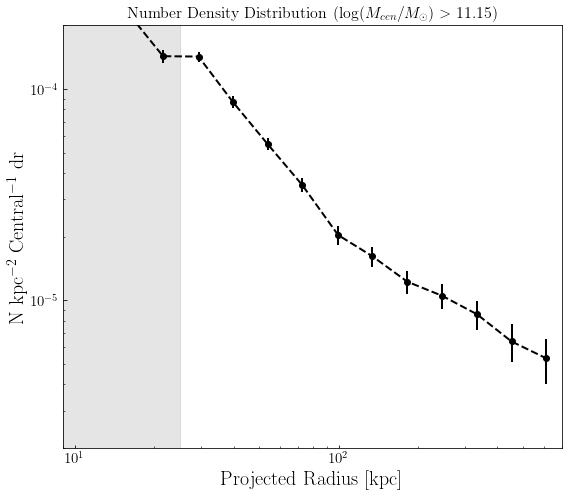

In [48]:
# all_z curve

# combine redshift bin
path = 'clauds_cat_v2020/total_sample_v2cat_masscut_1020/'

print(field_names)
radial_all = np.zeros(14)
radial_all_err_square = np.zeros(14)
radial_ssf = np.zeros(14)
radial_ssf_err_square = np.zeros(14)
radial_sq = np.zeros(14)
radial_sq_err_square = np.zeros(14)
count_all = 0
count_ssf = 0
count_sq = 0
start=4
fit_x = np.linspace(2,700,num=100)
bin_centers = np.load(path+'bin_centers.npy')
for z in [0.4, 0.6, 0.8]:
    radial_z_all = combine_deep_fields(field_names,'all','all','9.5','13.0', z, path=path)
    count_all += radial_z_all[2]
    radial_all += radial_z_all[0]*radial_z_all[2]
    radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
        
#     radial_z_ssf = combine_deep('all','ssf',masscut_low,'13.0', z, path=path)
#     count_ssf += radial_z_ssf[2]
#     radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
#     radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
        
#     radial_z_sq = combine_deep('all','sq',masscut_low,'13.0', z, path=path)
#     count_sq += radial_z_sq[2]
#     radial_sq += radial_z_sq[0]*radial_z_sq[2]
#     radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2

radial_all = (radial_all/count_all,np.sqrt(radial_all_err_square)/count_all)
# radial_ssf = (radial_ssf/count_ssf,np.sqrt(radial_ssf_err_square)/count_ssf)
# radial_sq = (radial_sq/count_sq,np.sqrt(radial_sq_err_square)/count_sq)

np.savetxt(path+'all_field_'+masscut_low+'_all_'+ 'all'+'.txt', radial_all)
# np.savetxt(path+'all_field_'+masscut_low+'_all_'+ 'ssf'+'.txt', radial_ssf)
# np.savetxt(path+'all_field_'+masscut_low+'_all_'+ 'sq'+'.txt', radial_sq)

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
z='allz'
bin_edges = np.load(path+'bin_centers.npy')
count_radial_allz = np.genfromtxt(path+'all_field_'+masscut_low+'_all_all.txt')
# count_radial_sf_allz = np.genfromtxt(path+'all_field_'+masscut_low+'_all_ssf.txt')
# count_radial_q_allz = np.genfromtxt(path+'all_field_'+masscut_low+'_all_sq.txt')
color=['k','b','r']
sat_type = ['All','SF','Q']
# dof = len(bin_edges)-start+1 - len(popt4) # degree of freedom
print(count_radial_allz[1])
####
plt.errorbar(bin_edges, count_radial_allz[0],count_radial_allz[1],fmt='ok--',linewidth=2)


########
# for i, radial in enumerate([count_radial_allz,count_radial_sf_allz,count_radial_q_allz]):
#     label='NFW+Sersic fit' if i==0 else ''
#     plt.errorbar(bin_edges, radial[0],radial[1],fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
#     popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_edges,radial[0],radial[1], 4)
#     perr_allz = np.sqrt(np.diag(pcov_allz))
#     print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
#     plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
# popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_edges,count_radial_allz[0],count_radial_allz[1], 4)
# plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
# plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')
# plt.annotate(r'$0.3<z<0.9$',xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')


plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([2e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.title('Number Density Distribution ($\log(M_{cen}/M_\odot)>11.15$)', fontsize=16)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()
# plt.savefig('figures/number_density_allz.png')
